2024-03-21 12:25:25.246947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-21 12:25:25.285469: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


preprocessor_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/339M [00:00<?, ?B/s]

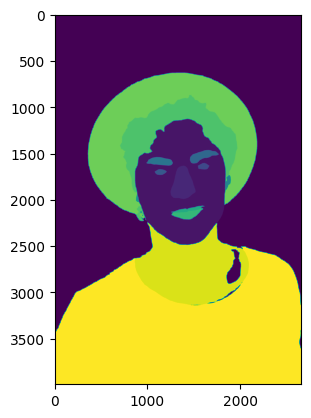

In [1]:
import torch
from torch import nn
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

from PIL import Image
import matplotlib.pyplot as plt
import requests

# convenience expression for automatically determining device
device = (
    "cuda"
    # Device for NVIDIA or AMD GPUs
    if torch.cuda.is_available()
    else "mps"
    # Device for Apple Silicon (Metal Performance Shaders)
    if torch.backends.mps.is_available()
    else "cpu"
)

# load models
image_processor = SegformerImageProcessor.from_pretrained("jonathandinu/face-parsing")
model = SegformerForSemanticSegmentation.from_pretrained("jonathandinu/face-parsing")
model.to(device)

# expects a PIL.Image or torch.Tensor
url = "https://images.unsplash.com/photo-1539571696357-5a69c17a67c6"
image = Image.open(requests.get(url, stream=True).raw)

# run inference on image
inputs = image_processor(images=image, return_tensors="pt").to(device)
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, ~height/4, ~width/4)

# resize output to match input image dimensions
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # H x W
                mode='bilinear',
                align_corners=False)

# get label masks
labels = upsampled_logits.argmax(dim=1)[0]

# move to CPU to visualize in matplotlib
labels_viz = labels.cpu().numpy()
plt.imshow(labels_viz)
plt.show()


In [2]:
labels.shape

torch.Size([3993, 2662])

In [7]:
parsing = labels.cpu().numpy()

In [25]:
import numpy as np

mask_image = np.zeros(parsing.shape)
mask_image[parsing==0] = 1.0
mask_image[parsing==18] = 1.0
mask_image[parsing==17] = 1.0




In [ ]:
# calculate segmentation area.

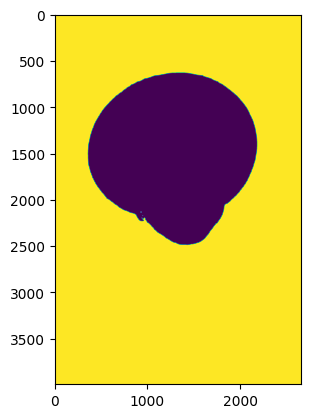

In [27]:
plt.imshow(mask_image)

In [ ]:
mask_image = 255 * (1 - mask_image)
mask_image = mask_image.astype(np.uint8)